In [1]:
from astropy import units as u
from astropy.coordinates import Angle
from zenith_to_latlon_error import get_latlon
from multilateration import multilateration, angular_dist
import time
from dataclasses import dataclass
from typing import Tuple

In [2]:
@dataclass
class StarInfo:
    ra: Angle
    dec: Angle 
    alt: Angle
    time: Tuple[int]

    def zd(self): 
        return Angle('90d') - self.alt

    def latlon(self):
        return get_latlon(*self.time, self.ra, self.dec)

In [3]:
@dataclass
class MultilaterationResult:
    elapsed_time: float
    lat: Angle
    lon: Angle
    alt_bias: Angle
    err_angular: Angle
    err_nm: float

    def __str__(self):
        out = ""
        out += f"Elapsed: {self.elapsed_time}s\n"
        out += f"Latitude: {self.lat.to_string(unit=u.degree)}\n"
        out += f"Longitude: {self.lon.to_string(unit=u.degree)}\n"
        out += f"Alt. Bias: {self.alt_bias.to_string(unit=u.degree)}\n"
        out += f"Err. Angular Separation: {self.err_angular.to_string(unit=u.degree)} \n"
        out += f"Err. in NM: {self.err_nm}\n"
        return out

In [4]:
from typing import List


def run_multilateration(actual_latitude: Angle, actual_longitude: Angle, stardata: List[StarInfo]) -> MultilaterationResult:
    # radian vs radians below is because lat / lon coordinates are Skyfield Angles
    # whereas the zd coordiantes are astropy angles
    points = [([l.radians for l in p.latlon()], p.zd().radian) for p in stardata]

    before = time.time()
    result_lat_rads, result_lon_rads, result_alt_bias_rads = multilateration(points).x
    elapsed = time.time() - before

    result_lat = Angle(result_lat_rads, u.radian)
    result_lon = Angle(result_lon_rads, u.radian)
    result_alt_bias = Angle(result_alt_bias_rads, u.radian)

    error_angular = angular_dist((result_lat.radian, result_lon.radian), (actual_latitude.radian, actual_longitude.radian))
    error_angular = Angle(error_angular, u.radian)

    error_nm = error_angular.arcminute

    return MultilaterationResult(elapsed, result_lat, result_lon, result_alt_bias, error_angular, error_nm)

In [5]:
# Params
alt_bias = Angle('3d')

# Actual
actual_latitude = Angle('+37d 10m 44.76s')
actual_longitude = Angle('-80d 21m 5.41s')

measure_time = (2022, 10, 24, 5, 25, 51)

# Betelgeuse
betelgeuse_ra = Angle('5h 55m 11.10s')
betelgeuse_dec = Angle('+7d 24m 30.6s')
betelgeuse_alt = Angle('+31d 48m 45.1s')

# Algenib
algenib_ra = Angle('0h 13m 15.31s')
algenib_dec = Angle('+15d 11m 10.1s')
algenib_alt = Angle('+55d 32m 08.6s')

# Schedar
schedar_ra = Angle('0h 40m 32.73s')
schedar_dec = Angle('+56d 32m 24.7s')
schedar_alt = Angle('+65d 07m 21.8s')

# Summarized data
stardata = [ 
    StarInfo(betelgeuse_ra, betelgeuse_dec, betelgeuse_alt, measure_time),
    StarInfo(algenib_ra, algenib_dec, algenib_alt, measure_time),
    StarInfo(schedar_ra, schedar_dec, schedar_alt, measure_time),
]

## Altitude Bias Error Analysis

Text(0, 0.5, 'Error (NM)')

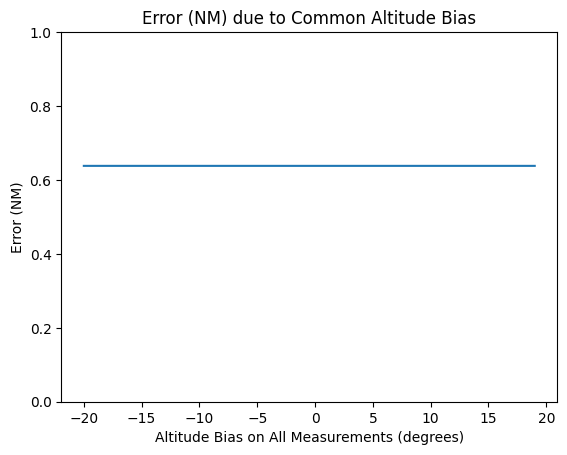

In [9]:
import dataclasses
import numpy as np
from matplotlib import pyplot as plt


def bias_data(stardata: List[StarInfo], bias: Angle) -> List[StarInfo]:
    return [dataclasses.replace(starinfo, alt=starinfo.alt+bias) for starinfo in stardata]

# Degrees
alt_biases = np.arange(-20, 20, 1)

# NM
alt_biases_errors = [
    run_multilateration(
        actual_latitude, 
        actual_longitude,
        bias_data(stardata, Angle(bias, u.degree))
    ).err_nm for bias in alt_biases]

plt.plot(alt_biases, alt_biases_errors)
plt.ylim([0, 1])
plt.title("Error (NM) due to Common Altitude Bias")
plt.xlabel("Altitude Bias on All Measurements (degrees)")
plt.ylabel("Error (NM)")



As expected, this is a flat line because we include an altitude bias term in our least-squares search.
In other words, our algorithm assumes that the altitude measurements are all off by some amount
and subtracts that amount from all the altitudes before calculating the distances. It doesn't know what
that bias is at first, but makes it a parameter of the least-squares search and can thus find it.

## Altitude Error Analysis (for just one measurement, not all of them)

In [25]:

def change_data(stardata: List[StarInfo], error: Angle, idx: int) -> List[StarInfo]:
    newdata = stardata.copy()
    newdata[idx] = dataclasses.replace(newdata[idx], alt=newdata[idx].alt+error)
    return newdata

# Degrees
single_alt_biases = np.linspace(-30, 30, 40)

# NM
single_alt_biases_errors = [
    [
        run_multilateration(
            actual_latitude, 
            actual_longitude,
            change_data(stardata, Angle(bias, u.arcminute), idx)
        ).err_nm for bias in single_alt_biases
    ]
    for idx in range(len(stardata))
]


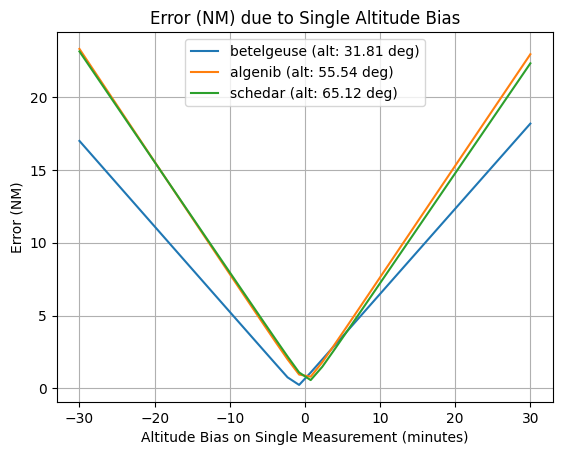

In [29]:

plt.figure()
plt.grid()

for i, _ in enumerate(stardata):
    plt.plot(single_alt_biases, single_alt_biases_errors[i])

plt.title("Error (NM) due to Single Altitude Bias")
plt.xlabel("Altitude Bias on Single Measurement (minutes)")
plt.ylabel("Error (NM)")
plt.legend([
    f"betelgeuse (alt: {stardata[0].alt:.2f})", 
    f"algenib (alt: {stardata[1].alt:.2f})", 
    f"schedar (alt: {stardata[2].alt:.2f})"
])

TODO - figure out what happens when altitude bias occurs on all three like below

## RA / Dec Error Analysis (for all measurements)


In [65]:
from astropy.coordinates import SkyCoord
from tqdm import tqdm

def perturb_skycoord(ra: Angle, dec: Angle, offset: Angle, direction: Angle) -> Tuple[Angle, Angle]:
    skycoord = SkyCoord(ra=ra, dec=dec)
    skycoord = skycoord.directional_offset_by(direction, offset)
    return skycoord.ra, skycoord.dec

def perturb_starinfo(starinfo: StarInfo, offset: Angle, direction: Angle) -> StarInfo:
    new_ra, new_dec = perturb_skycoord(starinfo.ra, starinfo.dec, offset, direction)
    return dataclasses.replace(starinfo, ra=new_ra, dec=new_dec)

def get_changed_data(data: List[StarInfo], stddev: float) -> List[StarInfo]:
    random_offsets_deg = np.random.normal(0, stddev, len(data))
    random_directions = np.random.random(len(data)) * 360

    newdata = [
        perturb_starinfo(
            star, 
            Angle(off, u.arcsecond), 
            Angle(dir, u.degree)
        ) 
        for (star, off, dir) in zip(data, random_offsets_deg, random_directions)
    ]
    return newdata

def get_errors_for_stddev(data: List[StarInfo], stddev: float, n: int) -> List[float]:
    datas = [get_changed_data(data, stddev) for _ in range(n)]
    results = [run_multilateration(actual_latitude, actual_longitude, data) for data in datas]
    errors = [result.err_nm for result in results]
    return errors


N = 200

stddevs = np.linspace(1, 120, 10)
stddevs_errors = [get_errors_for_stddev(stardata, stddev, N) for stddev in tqdm(stddevs)]



100%|██████████| 10/10 [01:36<00:00,  9.60s/it]


In [66]:

stddevs_stats = [(min(errors), np.mean(errors), max(errors)) for errors in stddevs_errors]
mins, avgs, maxs = zip(*stddevs_stats)


Text(0, 0.5, 'Output error, NM (min, avg, max)')

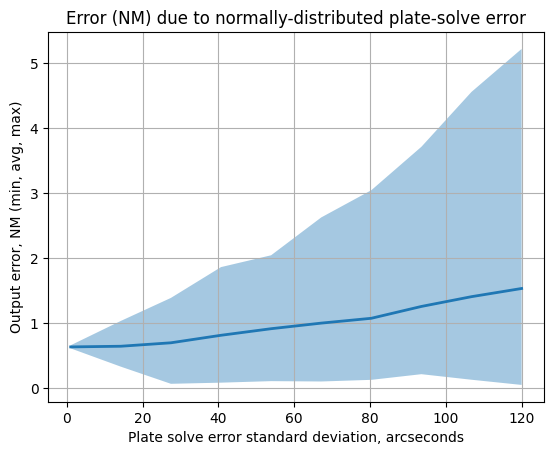

In [67]:
plt.figure()
plt.grid()

plt.plot(stddevs, avgs, linewidth=2)
plt.fill_between(stddevs, mins, maxs, alpha=0.4)
plt.title("Error (NM) due to normally-distributed plate-solve error")
plt.xlabel("Plate solve error standard deviation, arcseconds")
plt.ylabel("Output error, NM (min, avg, max)")

**TLDR - we want plate solve error < 20 arccsec if possible if using multilateration**

The above plot shows how output error can vary with plate-solving error.

It assumes that plate-solving can be modeled as finding the ideal RA / Dec plus
some Gaussian noise with some standard deviation in arcseconds.

The x-axis corresponds to the standard deviation of plate solving error (i.e., 20 means that
the distribution of plate solves has a standard deviation of 20 arcseconds from the true location).

For our simulation, I moved the true RA / Dec of each star in a random direction by a random
offset. The random offset was normally distributed with a standard deviation $\sigma$, which
is on the x-axis.

For each standard deviation, I simulated 80 of these trials (randomly moving each of the 3
stars by an offset sampled from the normal distribution with that standard deviation),
ran multilateration, and recorded the error in NM. The average of those 80 for each standard
deviation is shown in the blue line, and the minimum and maximum range is shown in the lighter
blue.
